In [29]:
import sys
import os
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from textblob import TextBlob
from langdetect import detect
import re
from collections import Counter
sns.set(rc={'figure.figsize':(11,8)})
sns.set_style('darkgrid')
import re
import random
import itertools
sys.path.append('../data')
stopwords_en = stopwords.words('english')

In [4]:
df = pd.read_csv("../data/Medium_Clean.csv")

In [5]:
N = 200000
sample = random.sample(range(df.shape[0]), N)
df = df.iloc[sample,:]

In [6]:
print(list(df))

['Unnamed: 0', 'Title', 'Subtitle', 'Image', 'Author', 'Publication', 'Year', 'Month', 'Day', 'Reading_Time', 'Claps', 'url', 'Author_url', 'Tag_ai', 'Tag_android', 'Tag_apple', 'Tag_architecture', 'Tag_art', 'Tag_artificial-intelligence', 'Tag_big-data', 'Tag_bitcoin', 'Tag_blacklivesmatter', 'Tag_blockchain', 'Tag_blog', 'Tag_blogging', 'Tag_books', 'Tag_branding', 'Tag_business', 'Tag_college', 'Tag_computer-science', 'Tag_creativity', 'Tag_cryptocurrency', 'Tag_culture', 'Tag_data', 'Tag_data-science', 'Tag_data-visualization', 'Tag_deep-learning', 'Tag_design', 'Tag_dogs', 'Tag_donald-trump', 'Tag_economics', 'Tag_education', 'Tag_energy', 'Tag_entrepreneurship', 'Tag_environment', 'Tag_ethereum', 'Tag_feminism', 'Tag_fiction', 'Tag_food', 'Tag_football', 'Tag_google', 'Tag_government', 'Tag_happiness', 'Tag_health', 'Tag_history', 'Tag_humor', 'Tag_inspiration', 'Tag_investing', 'Tag_ios', 'Tag_javascript', 'Tag_jobs', 'Tag_journalism', 'Tag_leadership', 'Tag_life', 'Tag_life-les

In [7]:
print("Number of rows and columns: {0}, {1}".format(df.shape[0], df.shape[1]))

Number of rows and columns: 200000, 108


In [8]:
tag_columns = list(filter(lambda x: re.match(r'^Tag', x), list(df)))

In [14]:
print(tag_columns)

['Tag_ai', 'Tag_android', 'Tag_apple', 'Tag_architecture', 'Tag_art', 'Tag_artificial-intelligence', 'Tag_big-data', 'Tag_bitcoin', 'Tag_blacklivesmatter', 'Tag_blockchain', 'Tag_blog', 'Tag_blogging', 'Tag_books', 'Tag_branding', 'Tag_business', 'Tag_college', 'Tag_computer-science', 'Tag_creativity', 'Tag_cryptocurrency', 'Tag_culture', 'Tag_data', 'Tag_data-science', 'Tag_data-visualization', 'Tag_deep-learning', 'Tag_design', 'Tag_dogs', 'Tag_donald-trump', 'Tag_economics', 'Tag_education', 'Tag_energy', 'Tag_entrepreneurship', 'Tag_environment', 'Tag_ethereum', 'Tag_feminism', 'Tag_fiction', 'Tag_food', 'Tag_football', 'Tag_google', 'Tag_government', 'Tag_happiness', 'Tag_health', 'Tag_history', 'Tag_humor', 'Tag_inspiration', 'Tag_investing', 'Tag_ios', 'Tag_javascript', 'Tag_jobs', 'Tag_journalism', 'Tag_leadership', 'Tag_life', 'Tag_life-lessons', 'Tag_love', 'Tag_machine-learning', 'Tag_marketing', 'Tag_medium', 'Tag_mobile', 'Tag_motivation', 'Tag_movies', 'Tag_music', 'Tag_n

## Hypothesis (EDA)

1) In the first part, we look at the measure of goodness of a blog - claps

2) Take a look at the tags and their distribution

3) We remove outliers (too short or too long titles and subtitles)

Looks like most of our blogs don't have that many claps.

In [10]:
df[tag_columns] = df[tag_columns].astype(int)
df['Num_Tags'] = df[tag_columns].apply(lambda x: sum(x), axis=1)

Text(0, 0.5, 'Number of datapoints')

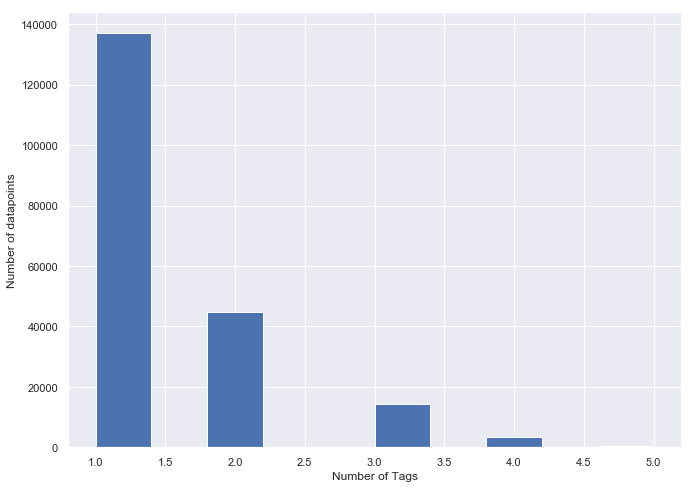

In [17]:
plt.hist(df['Num_Tags'])
plt.xlabel('Number of Tags')
plt.ylabel('Number of datapoints')

~70% of blogs have single tag. MOre than 20% have 2 tags, the rest with 3 or more

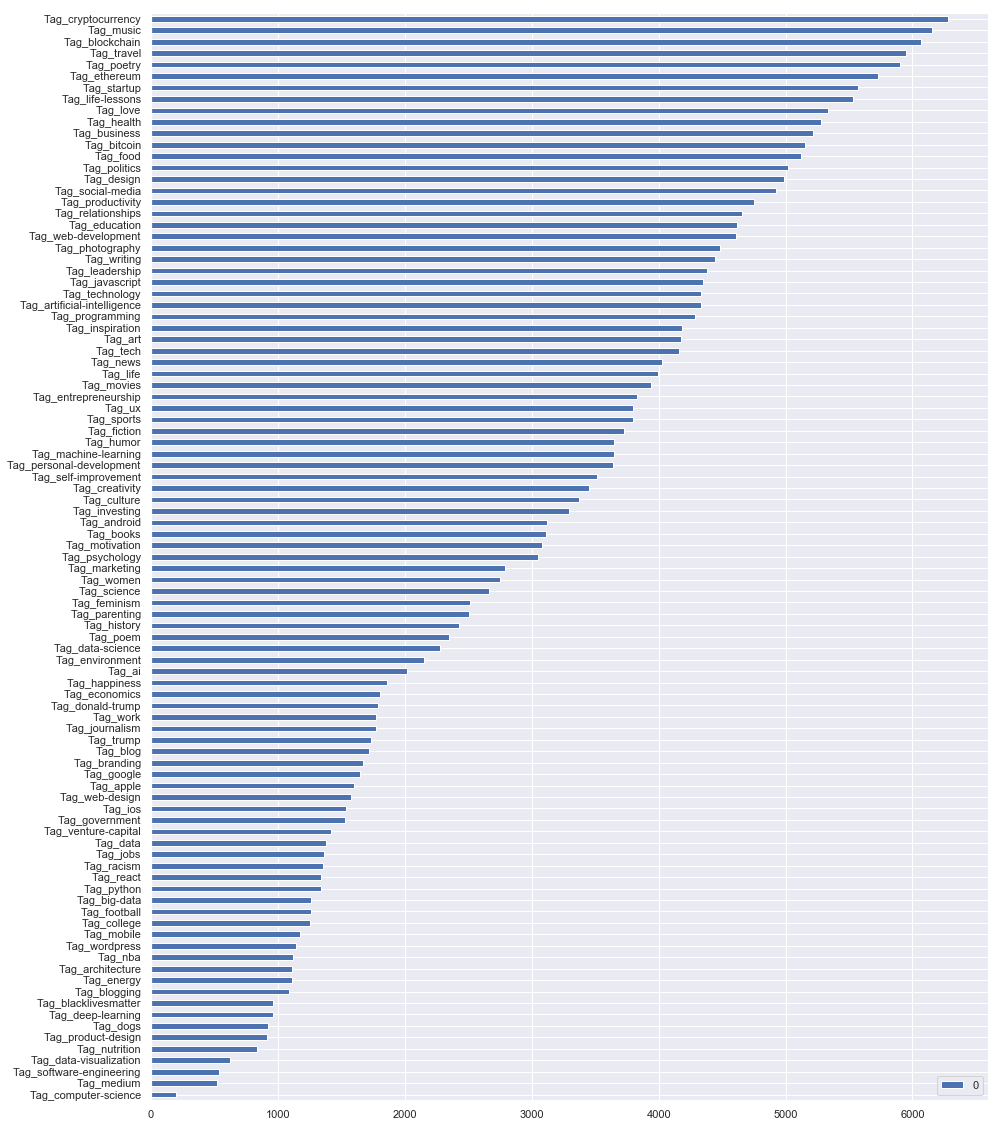

In [12]:
pd.DataFrame(df[tag_columns].sum().sort_values(ascending=True)).plot.barh(figsize=(15,20))

Out of sampled 200k datapoints, the most popular tag is not even 10% (~6000) of the 200k points. What all categories do we have here? Personal Development, Startups, Business, Tech, Art and Literature. Since we are looking at a multi label classification problem, let's explore the datapoints having multi-labels

### Multi Label Exploration

In [25]:
df_multi = df[df[tag_columns].sum(axis=1) > 1]

## Questions about multi-label cases
1) Popular pairs that occur together

2) Which tags have most multi-label cases

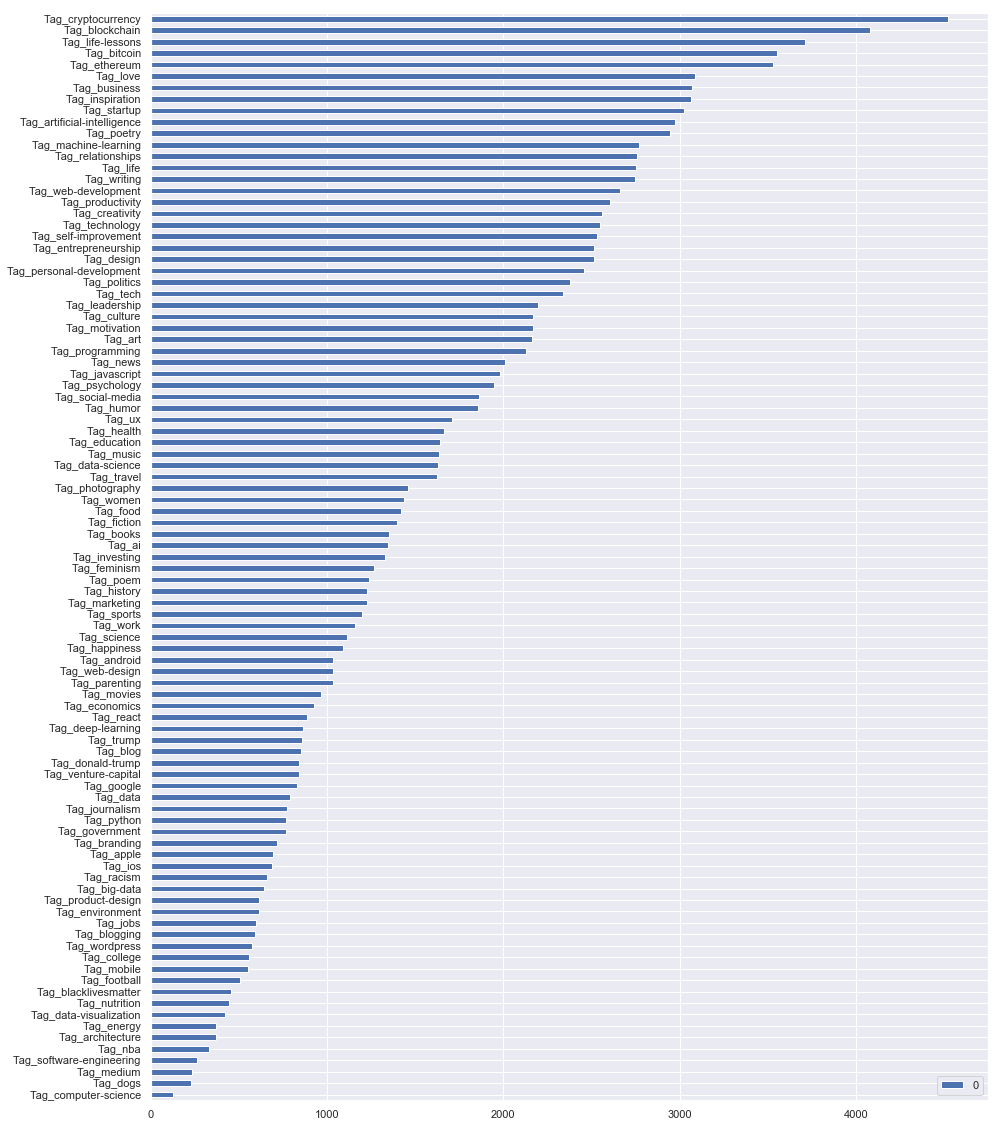

In [28]:
pd.DataFrame(df_multi[tag_columns].sum().sort_values(ascending=True)).plot.barh(figsize=(15,20))

## 10 Most Popular Tags
    1. cryptocurrency
    2. music
    3. blockchain
    4. travel
    5. poetry
    6. ethereum
    7. startups
    8. life-lesson
    9. love
    10. health


## 10 Most Popular Tags - Multi-Label Cases
    1. cryptocurrency
    2. blockchain
    3. life-lesson
    4. bitcoin
    5. ethereum
    6. love
    7. business
    8. inspiration
    9. startup
    10. artificial intelligence

In [33]:
counts = {}
for pair in itertools.combinations(tag_columns, 2):
    key = pair[0] + '-' + pair[1]
    counts[key] = (df[pair[0]] + df[pair[1]]==2).sum()

In [42]:
sorted_counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
for item in sorted_counts[:20]:
    print("Tag:",item[0], " --- Count: ", item[1])

Tag: Tag_bitcoin-Tag_cryptocurrency  --- Count:  2063
Tag: Tag_blockchain-Tag_cryptocurrency  --- Count:  2026
Tag: Tag_blockchain-Tag_ethereum  --- Count:  1785
Tag: Tag_cryptocurrency-Tag_ethereum  --- Count:  1497
Tag: Tag_bitcoin-Tag_ethereum  --- Count:  1496
Tag: Tag_artificial-intelligence-Tag_machine-learning  --- Count:  1405
Tag: Tag_bitcoin-Tag_blockchain  --- Count:  1267
Tag: Tag_love-Tag_relationships  --- Count:  1189
Tag: Tag_design-Tag_ux  --- Count:  822
Tag: Tag_javascript-Tag_web-development  --- Count:  802
Tag: Tag_data-science-Tag_machine-learning  --- Count:  787
Tag: Tag_poem-Tag_poetry  --- Count:  775
Tag: Tag_inspiration-Tag_motivation  --- Count:  748
Tag: Tag_javascript-Tag_react  --- Count:  728
Tag: Tag_love-Tag_poetry  --- Count:  714
Tag: Tag_web-design-Tag_web-development  --- Count:  704
Tag: Tag_deep-learning-Tag_machine-learning  --- Count:  697
Tag: Tag_ai-Tag_artificial-intelligence  --- Count:  650
Tag: Tag_entrepreneurship-Tag_startup  --- Coun

I guess we have a fair idea of how our target variables look. All the conclusions about the firther process are stated at the end of the notebook. For now, we'll move to another important set of variables - The input text

## High Level Questions (after basic preprocessing)
    1. Distribution of average length (number of words) of titles and subtitles
    2. How are they correlated
    3. Number of common words between title and subtitles
    4. Any null objects in title and subtitles

In [52]:
print("Datapoints (%) with null Title column: ", df['Title'].isnull().sum()/df.shape[0]*100)

Datapoints (%) with null Title column:  3.4835


In [54]:
print("Datapoints (%) with null Sub Title column: ", df['Subtitle'].isnull().sum()/df.shape[0]*100)

Datapoints (%) with null Sub Title column:  31.6245


In [55]:
df = df[df['Title'].notnull()]

In [56]:
#helper functions
def preprocess(sentence):
    try:
        tokens = word_tokenize(sentence.lower())
        tokens = [token for token in tokens if token not in string.punctuation and token not in stopwords_en]
        tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
        return ' '.join(tokens)
    except:
        print(sentence)

In [57]:
print(preprocess("Hello! I am A.I., your assistant"))    

hello ai assistant


In [58]:
title_wordcount = list(map(lambda x: len(preprocess(x).split()), df['Title']))

In [59]:
def basic_stats(num_list):
    print("Mean: ", np.mean(num_list))
    print("Median: ", np.median(num_list))
    print("Mode: ", scipy.stats.mode(num_list)[0][0])

print("For word count in title -")
basic_stats(title_wordcount)

For word count in title -
Mean:  4.766635756580481
Median:  4.0
Mode:  4


Text(0, 0.5, 'Count')

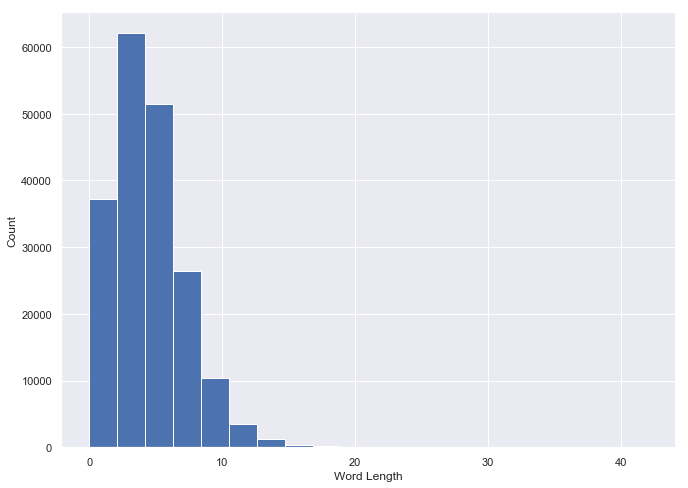

In [67]:
ax = plt.hist(title_wordcount, bins=20)
plt.xlabel("Word Length")
plt.ylabel("Count")

Now, we know that 31% of the subtitles are absent. So we'll consider only those datapoints where we have them. We are not removing them from the dataset all together. That would be expensive

In [71]:
df_sub = df[df['Subtitle'].notnull()]

In [72]:
df_sub.shape

(133119, 109)

In [95]:
subtitle_wordcount = list(map(lambda x: len(preprocess(x).split()), df_sub['Subtitle']))

In [74]:
basic_stats(subtitle_wordcount)

Mean:  10.98683884344083
Median:  9.0
Mode:  2


Text(0, 0.5, 'Count')

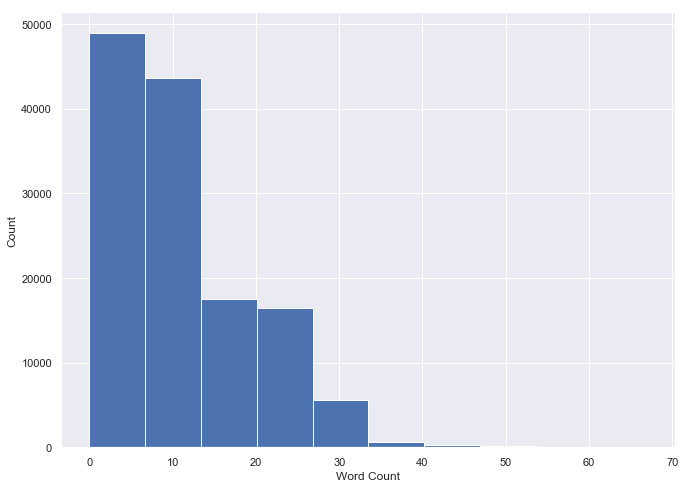

In [73]:
ax = plt.hist(subtitle_wordcount)
plt.xlabel("Word Count")
plt.ylabel("Count")

Text(0.5, 1.0, 'Correlation Word Count - Subtitle Count')

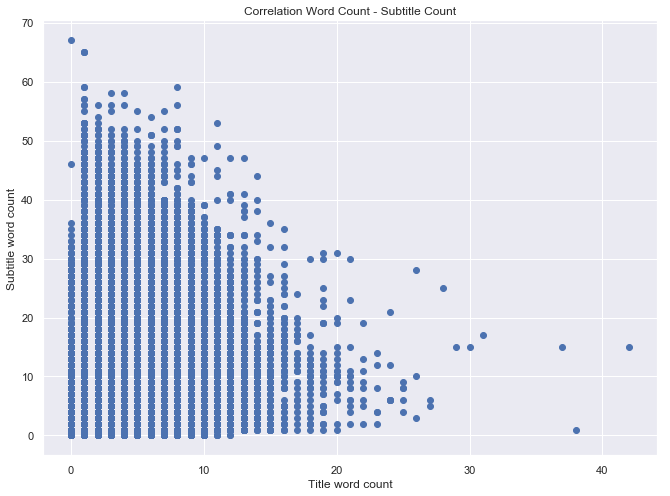

In [80]:
#correlation between title wordcount and subtitle wordcount
title_wordcount_sub =  list(map(lambda x: len(preprocess(x).split()), df_sub['Title']))
plt.scatter(title_wordcount_sub, subtitle_wordcount)
plt.xlabel("Title word count")
plt.ylabel("Subtitle word count")
plt.title("Correlation Word Count - Subtitle Count")

Surprisingly, the correlation was not the same as expected. If anything, it is negative

One last thing - Let's check if there is any difference between title word count between blogs having subtitle and the ones not having subtitle

Text(0, 0.5, 'Density')

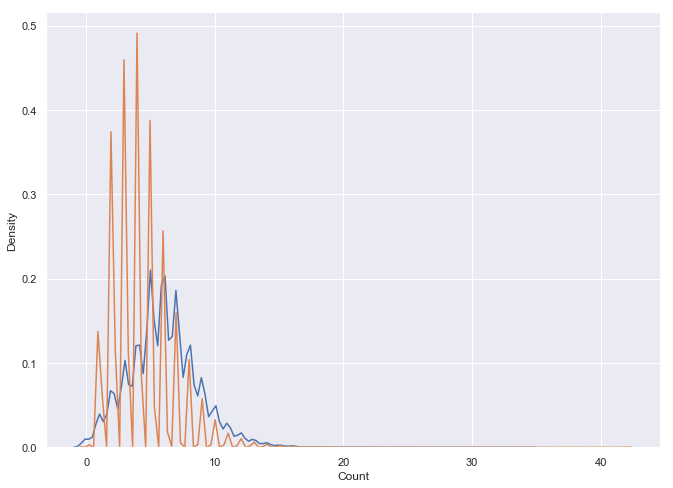

In [87]:
not_sub =  list(map(lambda x: len(preprocess(x).split()), df[df['Subtitle'].isnull()]['Title']))
ax = sns.kdeplot(not_sub)
ax = sns.kdeplot(title_wordcount_sub)
plt.xlabel("Count")
plt.ylabel("Density")

Not really. Meh!

## Discussion

What we know about the data - 

    1. Our data belongs to multiple topics across tech, business, life, etc.
    2. 70+% of the data has single tag.
    3. The most popular tag is not even 10% of the total points.
    4. Average title is 4 words long (post processing).
    5. Average subtitle is 10 words long (post processing).
    6. 31% of the blogs don't even have a subtitle.
    7. Against my belief, title and subtitle word count do not correlate.
    
Now, we remove outliers and in the end, decide our strategy on model building
    

In [88]:
#filter out articles with title wordcount > 15
MAX = 20
count_lt = [count<=MAX for count in title_wordcount]
df = df[count_lt]

In [89]:
print("Number of articles now: ", df.shape[0])
print("Number of articles deleted: ",len([count for count in title_wordcount if count>MAX]))

Number of articles now:  192970
Number of articles deleted:  63


Text(0, 0.5, 'Count')

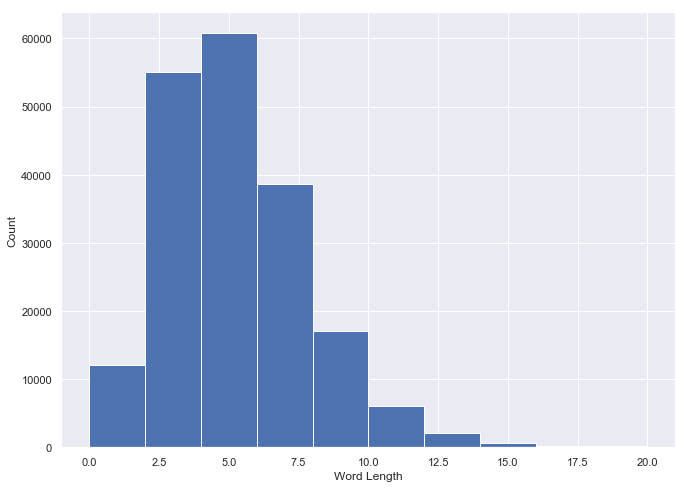

In [90]:
ax = plt.hist([count for count in title_wordcount if count<=MAX])
plt.xlabel("Word Length")
plt.ylabel("Count")

In [91]:
#Check subtitle
print("Percentage of blogs without subtitles: ", int(100*df['Subtitle'].isnull().sum()/df.shape[0]))

Percentage of blogs without subtitles:  31


In [92]:
df['Subtitle'] = df['Subtitle'].fillna('')

In [98]:
subtitle_wordcount = list(map(lambda x: len(preprocess(x).split()), df['Subtitle']))

In [99]:
MAX = 40
count_lt = [count<=40 for count in subtitle_wordcount]
df = df[count_lt]

In [100]:
print("Number of articles now: ", df.shape[0])
print("Number of articles deleted: ",len([count for count in subtitle_wordcount if count>MAX]))

Number of articles now:  192516
Number of articles deleted:  454


In [101]:
#final step - Joint title-subtitle analysis
df['Joint_Text'] = df[['Title', 'Subtitle']].apply(lambda x: x[0] + ' ' + x[1], axis=1)

C:\Users\Dhruvil\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [102]:
print(df.loc[0, 'Title'])
print(df.loc[0, 'Subtitle'])
print(df.loc[0, 'Joint_Text'])

KeyError: 0

In [103]:
combined_wordcount = list(map(lambda x: len(preprocess(x).split()), df['Joint_Text']))

Text(0, 0.5, 'Density')

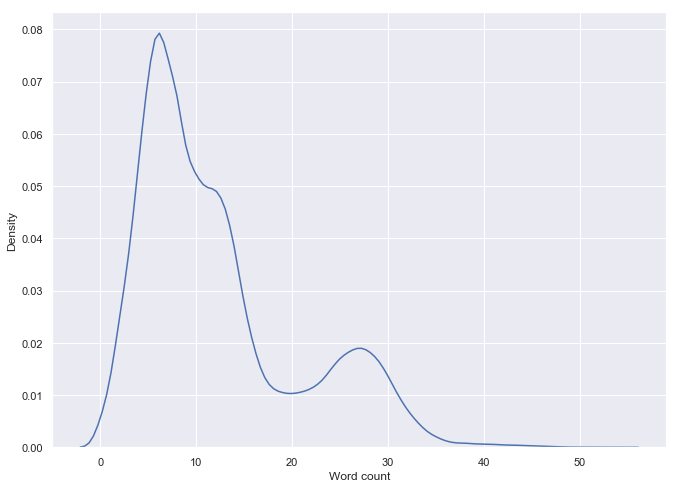

In [104]:
sns.kdeplot(combined_wordcount)
plt.xlabel("Word count")
plt.ylabel("Density")

In [105]:
def advanced_preprocess(sentence):
    sentence = re.subn(r'\S+.com', ' ', sentence)[0] #remove url or emials
    sentence = re.subn(r'\d+\.\d+', ' ', sentence)[0] #remove floating numbers
    sentence = re.subn(r'\d+', ' ', sentence)[0] #remove integers
    return sentence

In [106]:
#some more cleaning
def clean_nonaplha(x):
    return bool(set(string.ascii_letters).intersection(set(x)))

df = df[df['Joint_Text'].apply(lambda x: clean_nonaplha(x))]

In [107]:
df['Joint_Text'] = df['Joint_Text'].apply(lambda x: preprocess(x))
df['Joint_Text'] = df['Joint_Text'].apply(lambda x: advanced_preprocess(x))

C:\Users\Dhruvil\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Dhruvil\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [108]:
final_columns = ['Joint_Text'] + tag_columns

In [109]:
N = 50000
sample = random.sample(range(df.shape[0]), N)
df = df.iloc[sample,:]

In [110]:
df[final_columns].to_csv('C:/Users/Dhruvil/Desktop/Projects/MediumTag/data/clean.csv')

In [ ]:
pd.DataFrame(df[tag_columns].sum().sort_values(ascending=True)).plot.barh(figsize=(15,20))

In [ ]:
df[tag_columns].sum(axis=1)

## Final Remarks

    1. Since most of our blogs have a single tag, we create a primary model to predict if the blog will have single or multiple tags.
    2. If it is a single tag, then we have a normal secondary multiclass classifier
    3. If it isn't, then we move to another secondary model that does multilable classification
    4. The primary model is trained on the entire dataset
    5. The first secondary model is trained on single tag data
    6. The second secondary model is trained on multilabel cases 